Dataset shape: (3744, 15)

Column names:
['student_code', 'source_file', 'json_filename', 'task_id', 'task_inner_id', 'annotation_id', 'text', 'label_text', 'label_numeric', 'completed_by', 'annotation_created_at', 'annotation_updated_at', 'task_created_at', 'task_updated_at', 'lead_time_seconds']
SEPARATING TEST DATASET

Test holdout dataset: 132 records
  K3I7DL: 92 records
  BCLHKC (otp): 40 records

Working dataset (for exploration and training): 3612 records

Test holdout saved to: ../data/final/test.csv

Continuing exploration with working dataset...
First 3 rows:
  student_code                         source_file            json_filename  \
0       A5VHUA  26a1b32c-belvarosi_epito_aszf.json  merged_annotations.json   
1       A5VHUA  26a1b32c-belvarosi_epito_aszf.json  merged_annotations.json   
2       A5VHUA  26a1b32c-belvarosi_epito_aszf.json  merged_annotations.json   

   task_id  task_inner_id  annotation_id  \
0     1430              1            187   
1     1431        

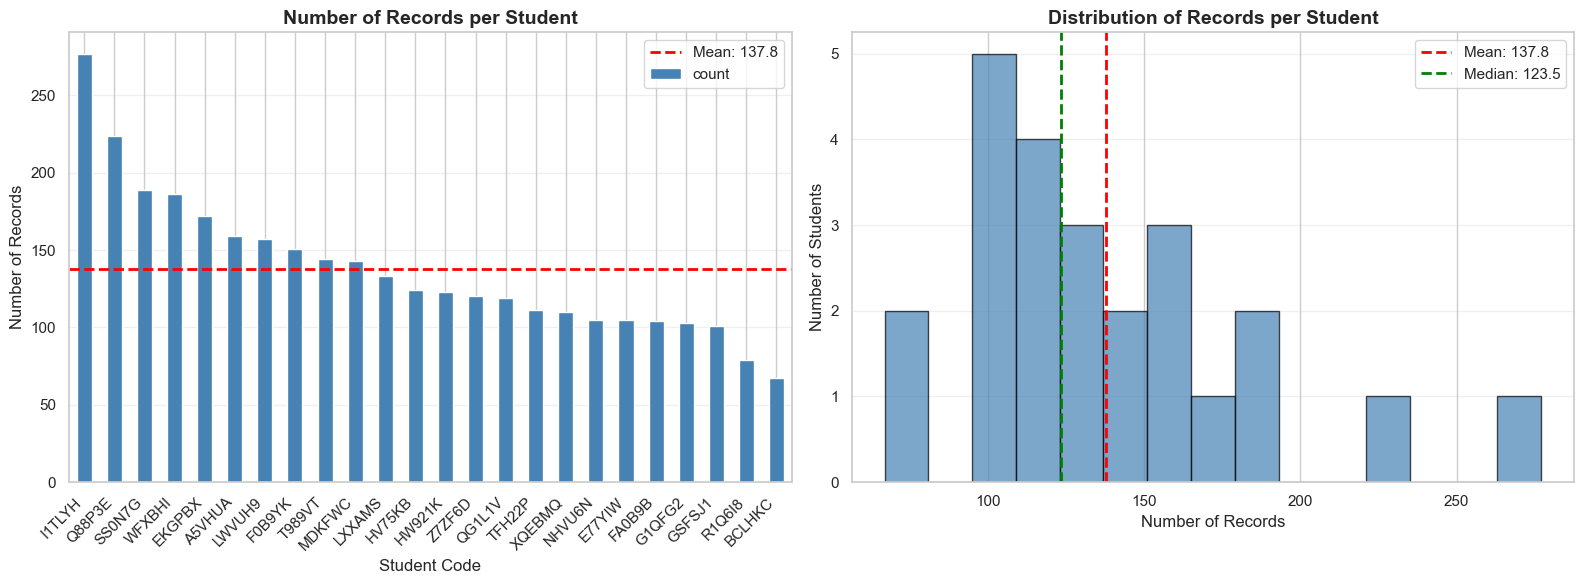

TEXT LENGTH DISTRIBUTION ANALYSIS

Text length statistics (characters):
count        3306.0
mean     407.547187
std      460.874647
min             2.0
25%           173.0
50%           309.0
75%           501.0
max          9223.0
Name: text_length, dtype: Float64

Percentiles:
   1th: 23 chars
   5th: 56 chars
  10th: 88 chars
  25th: 173 chars
  50th: 309 chars
  75th: 501 chars
  90th: 787 chars
  95th: 1002 chars
  99th: 1922 chars


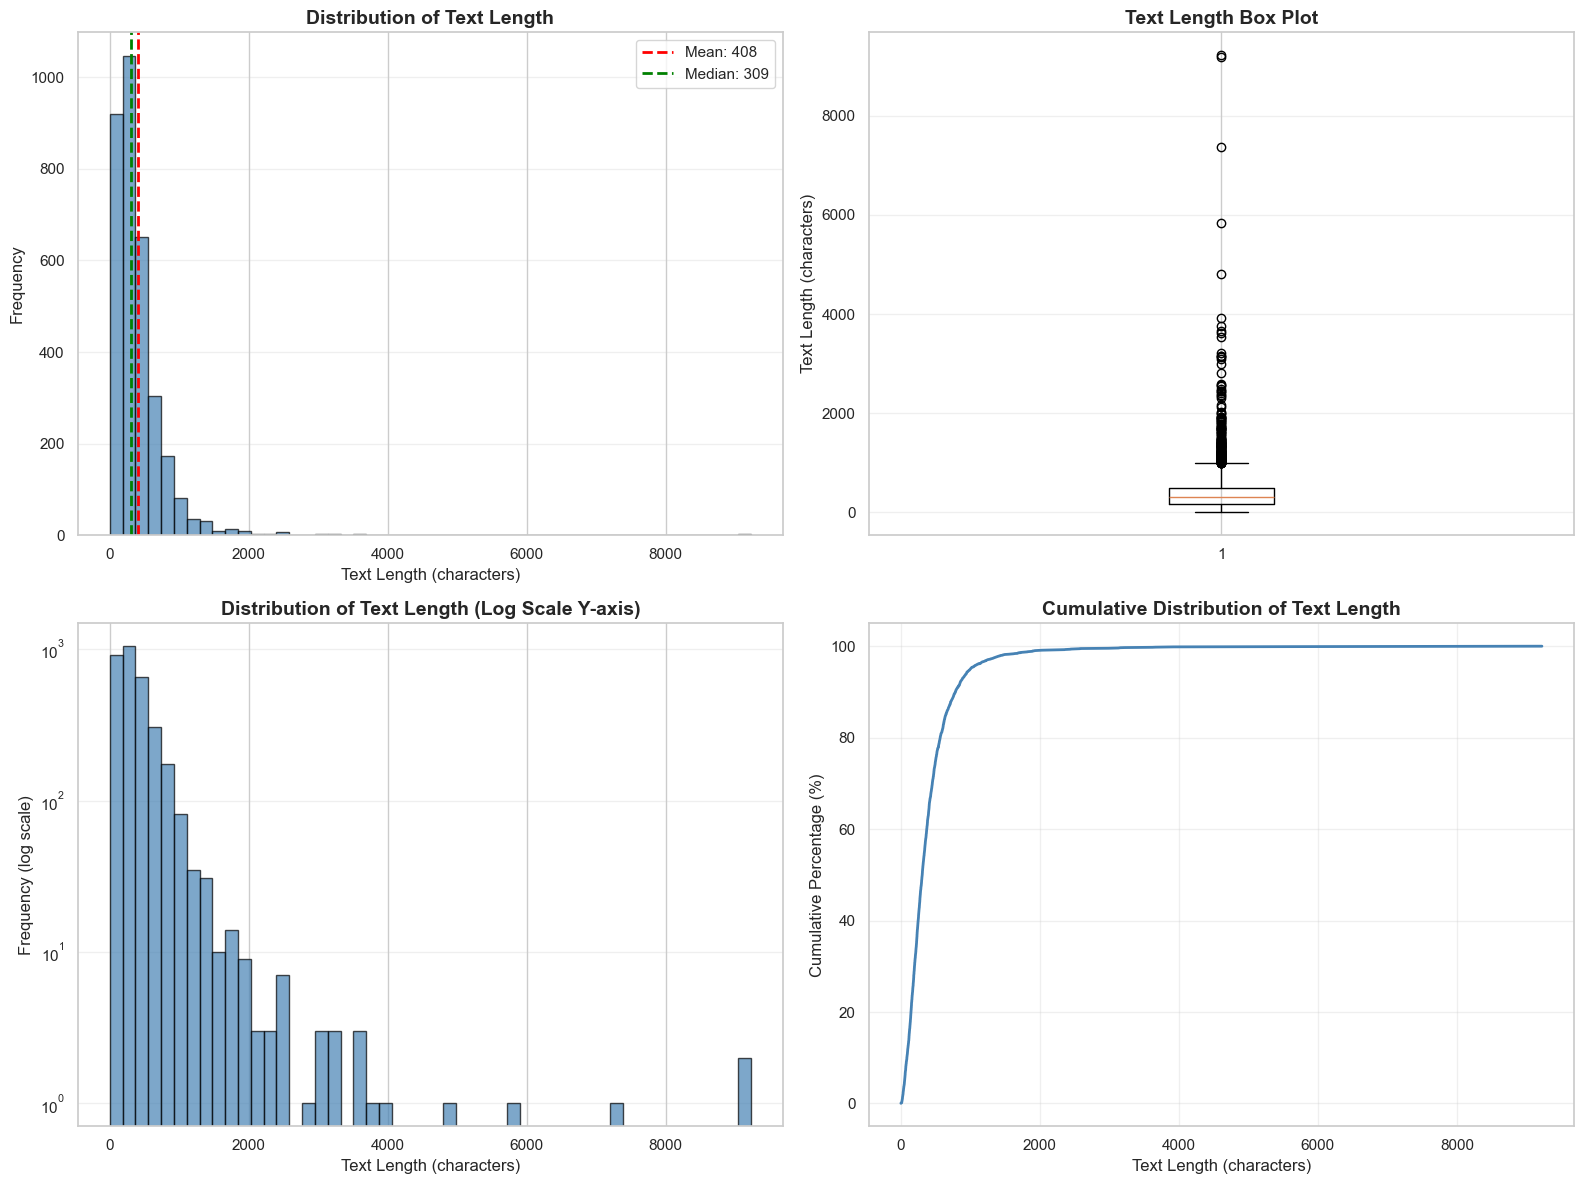

LABEL DISTRIBUTION ANALYSIS

Label distribution:
  Label 1:  160 ( 4.84%)
  Label 2:  365 (11.04%)
  Label 3:  699 (21.14%)
  Label 4: 1013 (30.64%)
  Label 5: 1069 (32.34%)

Total: 3306


Label text distribution:
  5-Könnyen érthető             : 1069 (32.34%)
  4-Érthető                     : 1013 (30.64%)
  3-Többé/kevésbé megértem      :  699 (21.14%)
  2-Nehezen érthető             :  365 (11.04%)
  1-Nagyon nehezen érthető      :  160 ( 4.84%)


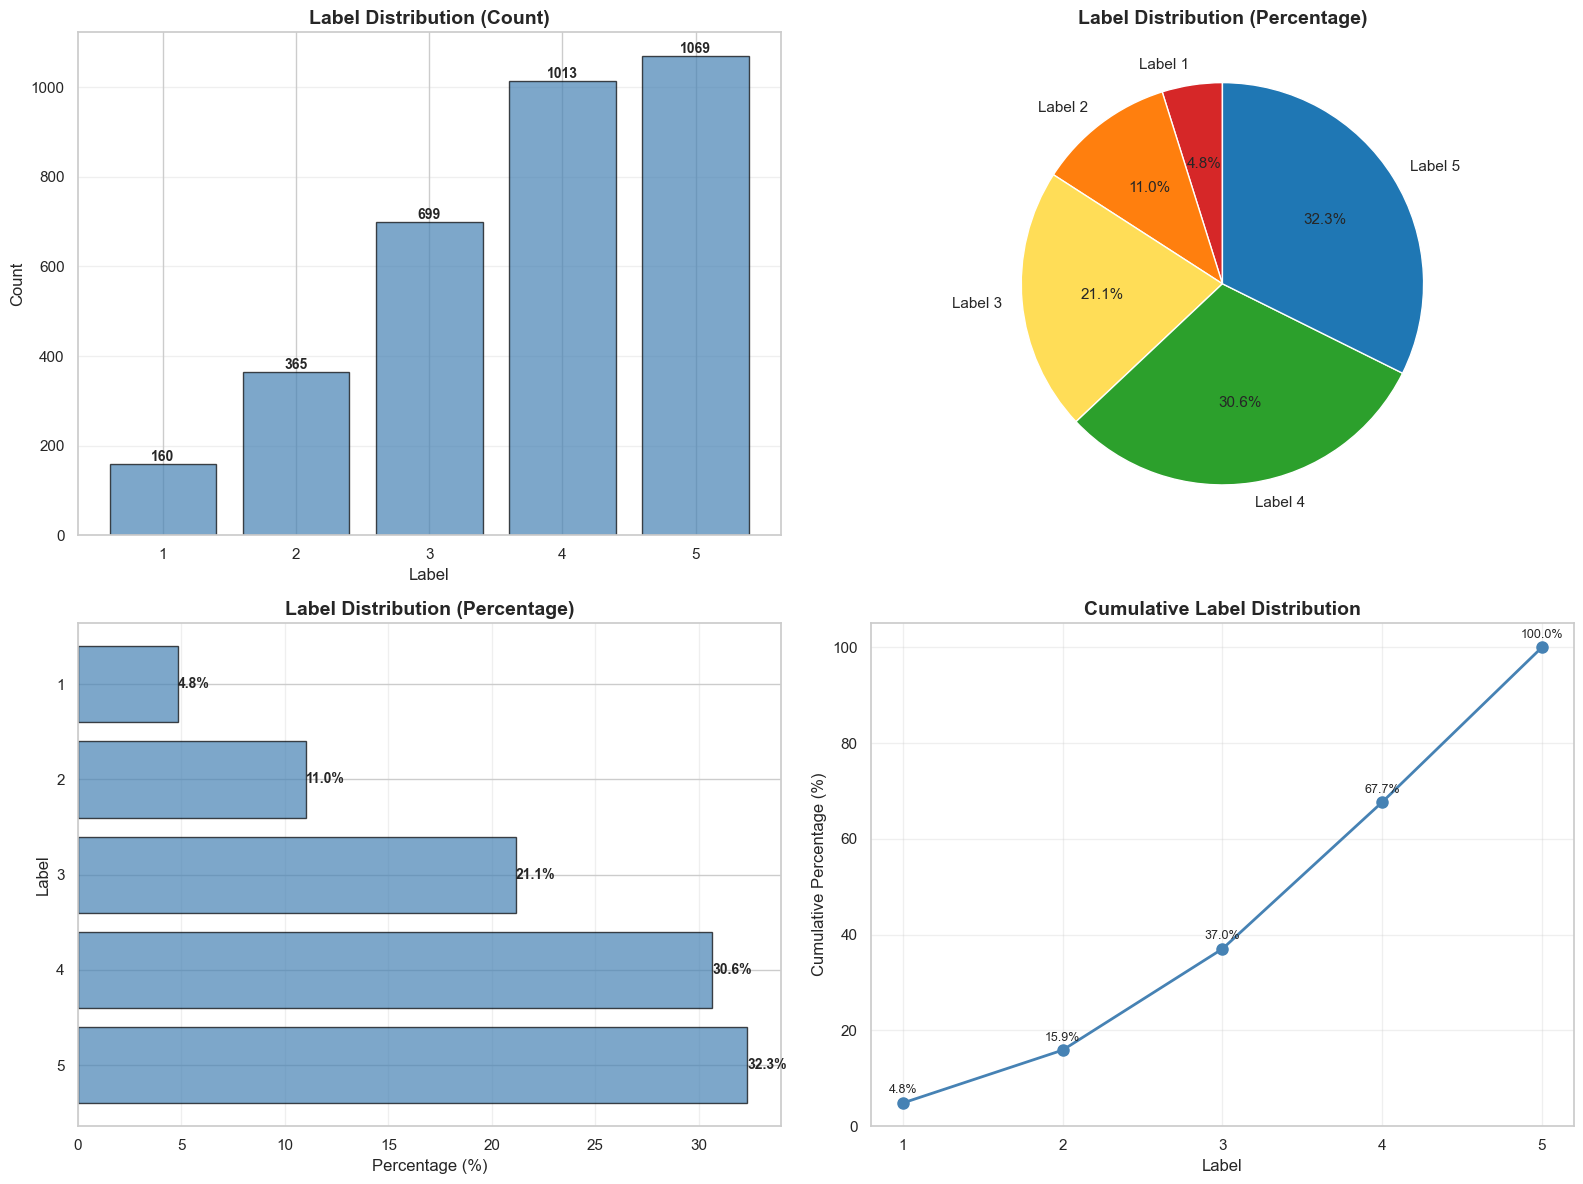

LEAD TIME DISTRIBUTION ANALYSIS

Lead time statistics (seconds):
count    3306.000000
mean       42.880206
std       221.870038
min         0.369000
25%         6.434500
50%        11.730000
75%        21.915750
max      4976.067000
Name: lead_time_seconds, dtype: float64


Lead time in different units:
  Mean: 42.88 seconds (0.71 minutes)
  Median: 11.73 seconds (0.20 minutes)
  Min: 0.37 seconds
  Max: 4976.07 seconds (82.93 minutes)

Percentiles:
   5th:   1.74 seconds ( 0.03 minutes)
  10th:   3.25 seconds ( 0.05 minutes)
  25th:   6.43 seconds ( 0.11 minutes)
  50th:  11.73 seconds ( 0.20 minutes)
  75th:  21.92 seconds ( 0.37 minutes)
  90th:  49.92 seconds ( 0.83 minutes)
  95th:  91.62 seconds ( 1.53 minutes)
  99th: 802.38 seconds (13.37 minutes)


Lead time by label:
  Label 1: Mean= 76.48s, Median= 15.07s, Std=254.12s
  Label 2: Mean= 43.28s, Median= 15.53s, Std=147.35s
  Label 3: Mean= 65.01s, Median= 17.86s, Std=299.69s
  Label 4: Mean= 41.30s, Median= 13.30s, Std=200.22s


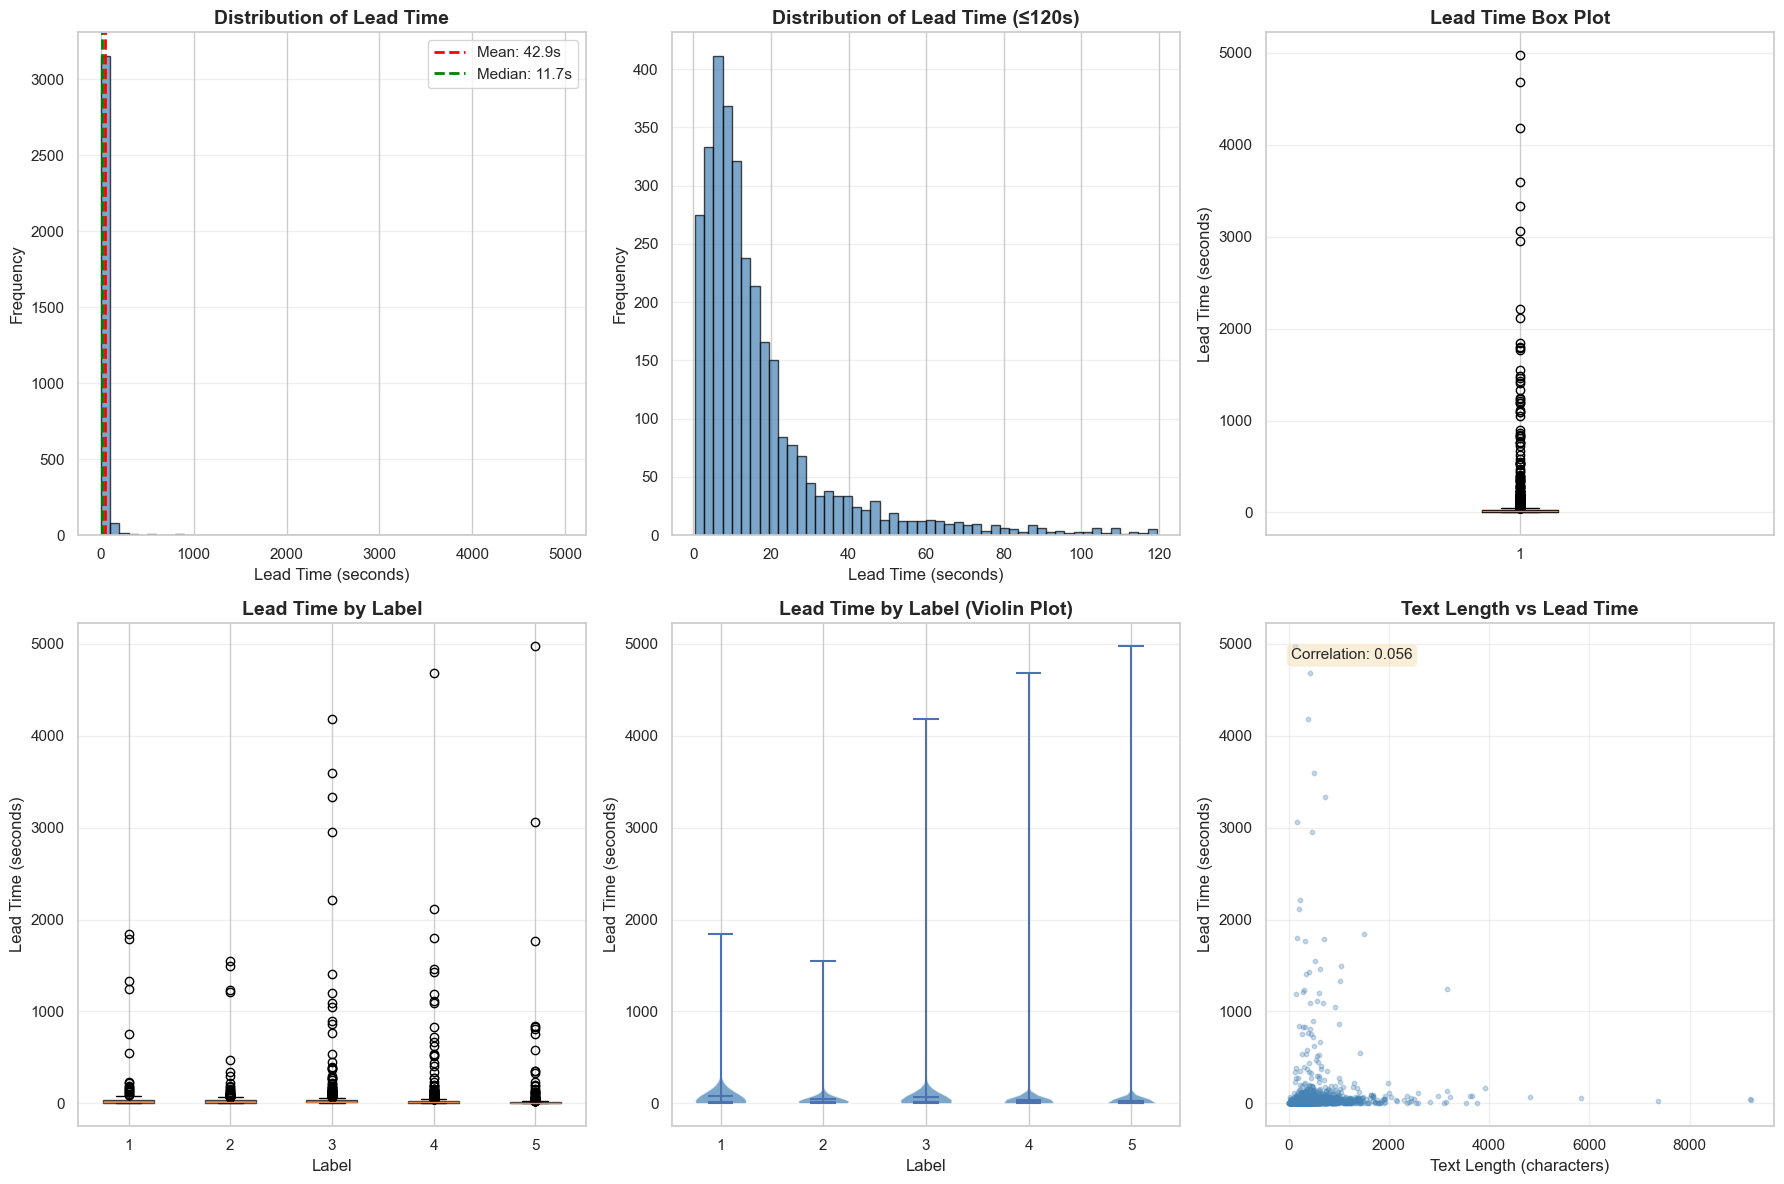

INVESTIGATING SHORT TEXTS

Number of texts shorter than 50 characters: 137

All short texts (sorted by length, descending):
--------------------------------------------------------------------------------

[Length: 49 chars] Student: Q88P3E | Label: 2 | Lead:   6.56s
  Text: '3.2.4. Erste Lakossági SMS szolgáltatás igénylése'
  Source: erste-diakhitel-kozpont_cimkezes.json

[Length: 49 chars] Student: F0B9YK | Label: 5 | Lead:   8.90s
  Text: 'A fogyasztó elállási nyilatkozatának érvényessége'
  Source: holyduck_aszf.json

[Length: 49 chars] Student: LXXAMS | Label: 5 | Lead:   1.67s
  Text: 'o vírussal fertőzött csatolt állományt tartalmaz,'
  Source: budapestgo_aszf.json

[Length: 49 chars] Student: Q88P3E | Label: 5 | Lead:   3.15s
  Text: '3. SZÁMLAVEZETÉS ÁLTALÁNOS SZERZŐDÉSES FELTÉTELEI'
  Source: erste-diakhitel-kozpont_cimkezes.json

[Length: 48 chars] Student: Q88P3E | Label: 3 | Lead:  36.24s
  Text: '3.3.4. A Bankszámlaszerződés hatálya, megszűnése'
  Source: erste-diakhitel

In [72]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Iterable, Dict, Any, Tuple, List

import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# ----------------------------
# Setup
# ----------------------------

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

SRC_CSV = Path("../data/aggregated/labeled_data.csv")
DST_DIR = Path("../data/final")
DST_DIR.mkdir(parents=True, exist_ok=True)

PATH_TEST = DST_DIR / "test.csv"
PATH_TRAIN = DST_DIR / "train.csv"

LABELS = [1, 2, 3, 4, 5]

# NOTE:
# In the original notebook a "MIN 40" message was printed, but the *actual* filter used >= 50.
# We keep the same functional behavior: min_len = 50.
MIN_LEN_CHARS = 50
MIN_MEAN_LEAD = 10.0


# ----------------------------
# Configuration objects
# ----------------------------

@dataclass(frozen=True)
class HoldoutSpec:
    student: str
    source_contains: str | None = None  # case-insensitive substring in source_file


TEST_HOLDOUT: List[HoldoutSpec] = [
    HoldoutSpec(student="K3I7DL", source_contains=None),
    HoldoutSpec(student="BCLHKC", source_contains="otp"),
]


# ----------------------------
# Helper functions (small + composable)
# ----------------------------

def banner(title: str) -> None:
    print("=" * 80)
    print(title)
    print("=" * 80)


def safe_str_col(df: pd.DataFrame, col: str) -> pd.Series:
    if col not in df.columns:
        return pd.Series([""] * len(df), index=df.index, dtype="string")
    return df[col].astype("string")


def holdout_selector(df: pd.DataFrame, specs: Iterable[HoldoutSpec]) -> pd.Series:
    """
    Build holdout selection mask using explicit specs.
    - student-only rule: match student_code
    - student + substring rule: match student_code AND source_file contains substring
    """
    student_col = safe_str_col(df, "student_code")
    src_col = safe_str_col(df, "source_file")

    mask = pd.Series(False, index=df.index)
    for s in specs:
        m = student_col.eq(s.student)
        if s.source_contains is not None:
            m = m & src_col.str.contains(s.source_contains, case=False, na=False)
        mask |= m
    return mask


def pick_columns(df: pd.DataFrame) -> pd.DataFrame:
    needed = [
        "student_code",
        "json_filename",
        "text",
        "label_text",
        "label_numeric",
        "annotation_created_at",
        "lead_time_seconds",
    ]
    out = df.loc[:, needed].copy()
    out = out.rename(columns={"annotation_created_at": "labeled_at"})
    return out


def show_basic(df: pd.DataFrame) -> None:
    print("First 3 rows:")
    print(df.head(3))

    print("\n" + "=" * 80 + "\n")
    print("Data types:")
    print(df.dtypes)

    print("\n" + "=" * 80 + "\n")
    print("Missing values:")
    print(df.isnull().sum())


def duplicate_report(df: pd.DataFrame) -> None:
    print("Duplicate analysis:")
    print(f"Total records: {len(df)}")
    print(f"Unique texts: {df['text'].nunique()}")
    print(f"Duplicate texts: {len(df) - df['text'].nunique()}")

    print("\n" + "=" * 80 + "\n")
    dups = df.loc[df.duplicated(subset=["text"], keep=False)].copy()
    print(f"Records with duplicate texts: {len(dups)}")

    if len(dups) == 0:
        return

    freq = dups.groupby("text").size().sort_values(ascending=False)
    print("\nTop 10 most duplicated texts (by frequency):")
    print(freq.head(10))

    print("\n" + "=" * 80 + "\n")
    print("Label variation in duplicate texts:")

    stats_tbl = (
        dups.groupby("text")
        .agg(
            count=("label_numeric", "size"),
            mean_label=("label_numeric", "mean"),
            std_label=("label_numeric", "std"),
            min_label=("label_numeric", "min"),
            max_label=("label_numeric", "max"),
            unique_students=("student_code", "nunique"),
        )
        .round(2)
        .sort_values("count", ascending=False)
    )
    print(stats_tbl.head(10))


def dedupe_by_policy(df: pd.DataFrame) -> pd.DataFrame:
    """
    Same *behavior*, different implementation:

    For each text group:
      - if all labels agree -> keep earliest occurrence (stable)
      - else -> keep the row with maximum lead_time_seconds (tie -> earliest)
    """
    tmp = df.copy()
    tmp["_ord"] = np.arange(len(tmp), dtype=np.int64)

    grp = tmp.groupby("text", sort=False)
    tmp["_label_nuniq"] = grp["label_numeric"].transform("nunique")
    tmp["_lead"] = pd.to_numeric(tmp["lead_time_seconds"], errors="coerce").fillna(-1.0)

    # prefer max lead only when disagreement exists
    tmp["_lead_key"] = np.where(tmp["_label_nuniq"] > 1, -tmp["_lead"], 0.0)

    chosen = (
        tmp.sort_values(["text", "_label_nuniq", "_lead_key", "_ord"], ascending=[True, True, True, True])
        .drop_duplicates(subset=["text"], keep="first")
        .drop(columns=["_ord", "_label_nuniq", "_lead", "_lead_key"])
        .reset_index(drop=True)
    )
    return chosen


def with_text_len(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["text_length"] = out["text"].astype("string").str.len()
    return out


def filter_text_len(df: pd.DataFrame, min_chars: int) -> pd.DataFrame:
    return df.loc[df["text_length"] >= min_chars].copy()


def compute_student_speed(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.groupby("student_code", as_index=False)
        .agg(mean_lead_time=("lead_time_seconds", "mean"), count=("lead_time_seconds", "size"))
        .sort_values("mean_lead_time")
    )


def drop_fast_students(df: pd.DataFrame, min_mean_time: float) -> Tuple[pd.DataFrame, List[str], pd.DataFrame]:
    speed = compute_student_speed(df)
    remove = speed.loc[speed["mean_lead_time"] < min_mean_time, "student_code"].tolist()
    kept = df.loc[~df["student_code"].isin(remove)].copy()
    return kept, remove, speed


def chisq_bias_table(df: pd.DataFrame) -> pd.DataFrame:
    overall = df["label_numeric"].value_counts(normalize=True).sort_index()
    labs = list(overall.index)

    rows: List[Dict[str, Any]] = []
    for student, sub in df.groupby("student_code", sort=True):
        obs = sub["label_numeric"].value_counts().reindex(labs, fill_value=0).astype(float).values
        exp = (overall * len(sub)).reindex(labs, fill_value=0).astype(float).values

        if exp.sum() <= 0:
            chi2, p = np.nan, np.nan
        else:
            chi2, p = stats.chisquare(obs, exp)

        rows.append(
            {
                "student": student,
                "count": int(len(sub)),
                "mean_label": float(sub["label_numeric"].mean()),
                "std_label": float(sub["label_numeric"].std()),
                "chi2": float(chi2),
                "p_value": float(p),
                "significant": bool(p < 0.05) if not np.isnan(p) else False,
            }
        )

    return pd.DataFrame(rows).sort_values("p_value")


# ----------------------------
# Stage A: Load
# ----------------------------

raw_df = pd.read_csv(SRC_CSV)

print(f"Dataset shape: {raw_df.shape}")
print("\nColumn names:")
print(raw_df.columns.tolist())

# ----------------------------
# Stage B: Early test holdout split + save test immediately
# ----------------------------

banner("SEPARATING TEST DATASET")

is_holdout = holdout_selector(raw_df, TEST_HOLDOUT)

df_test = raw_df.loc[is_holdout].copy()
df_work = raw_df.loc[~is_holdout].copy()

print(f"\nTest holdout dataset: {len(df_test)} records")
print(f"  K3I7DL: {len(df_test.loc[df_test['student_code'].astype(str).eq('K3I7DL')])} records")
print(
    f"  BCLHKC (otp): {len(df_test.loc[df_test['student_code'].astype(str).eq('BCLHKC')])} records"
)
print(f"\nWorking dataset (for exploration and training): {len(df_work)} records")

df_test.to_csv(PATH_TEST, index=False, encoding="utf-8")
print(f"\nTest holdout saved to: {PATH_TEST}")
print("\nContinuing exploration with working dataset...")
print("=" * 80)

# ----------------------------
# Stage C: Quick sanity checks
# ----------------------------

show_basic(df_work)

# ----------------------------
# Stage D: Keep relevant columns + rename
# ----------------------------

curated = pick_columns(df_work)

print(f"Cleaned dataset shape: {curated.shape}")
print("\nFirst 3 rows:")
print(curated.head(3))

# ----------------------------
# Stage E: Duplicate reporting + resolution
# ----------------------------

duplicate_report(curated)

deduped = dedupe_by_policy(curated)

print(f"\nFinal dataset size: {len(deduped)}")
print(f"Records removed: {len(curated) - len(deduped)}")
print(f"Unique texts in final dataset: {deduped['text'].nunique()}")

# ----------------------------
# Stage F: Student distribution (same info, different code)
# ----------------------------

banner("STUDENT DISTRIBUTION ANALYSIS")

student_hist = deduped["student_code"].value_counts().sort_values(ascending=False)

print(f"\nTotal unique students: {deduped['student_code'].nunique()}")
print("\nRecords per student:")
print(student_hist)

print("\nSummary statistics:")
print(f"  Mean: {student_hist.mean():.2f}")
print(f"  Median: {student_hist.median():.2f}")
print(f"  Min: {student_hist.min()}")
print(f"  Max: {student_hist.max()}")
print(f"  Std: {student_hist.std():.2f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

student_hist.plot(kind="bar", ax=axes[0], color="steelblue")
axes[0].set_title("Number of Records per Student", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Student Code", fontsize=12)
axes[0].set_ylabel("Number of Records", fontsize=12)
axes[0].axhline(student_hist.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {student_hist.mean():.1f}")
axes[0].legend()
axes[0].grid(axis="y", alpha=0.3)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha="right")

axes[1].hist(student_hist.values, bins=15, color="steelblue", edgecolor="black", alpha=0.7)
axes[1].set_title("Distribution of Records per Student", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Number of Records", fontsize=12)
axes[1].set_ylabel("Number of Students", fontsize=12)
axes[1].axvline(student_hist.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {student_hist.mean():.1f}")
axes[1].axvline(student_hist.median(), color="green", linestyle="--", linewidth=2,
                label=f"Median: {student_hist.median():.1f}")
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Stage G: Text length stats + plots
# ----------------------------

banner("TEXT LENGTH DISTRIBUTION ANALYSIS")

deduped = with_text_len(deduped)

print("\nText length statistics (characters):")
print(deduped["text_length"].describe())

extra_p = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
print("\nPercentiles:")
for p in extra_p:
    print(f"  {int(p * 100):2d}th: {deduped['text_length'].quantile(p):.0f} chars")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].hist(deduped["text_length"], bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0, 0].set_title("Distribution of Text Length", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Text Length (characters)", fontsize=12)
axes[0, 0].set_ylabel("Frequency", fontsize=12)
axes[0, 0].axvline(deduped["text_length"].mean(), color="red", linestyle="--", linewidth=2,
                   label=f"Mean: {deduped['text_length'].mean():.0f}")
axes[0, 0].axvline(deduped["text_length"].median(), color="green", linestyle="--", linewidth=2,
                   label=f"Median: {deduped['text_length'].median():.0f}")
axes[0, 0].legend()
axes[0, 0].grid(axis="y", alpha=0.3)

axes[0, 1].boxplot(deduped["text_length"], vert=True)
axes[0, 1].set_title("Text Length Box Plot", fontsize=14, fontweight="bold")
axes[0, 1].set_ylabel("Text Length (characters)", fontsize=12)
axes[0, 1].grid(axis="y", alpha=0.3)

axes[1, 0].hist(deduped["text_length"], bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[1, 0].set_title("Distribution of Text Length (Log Scale Y-axis)", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Text Length (characters)", fontsize=12)
axes[1, 0].set_ylabel("Frequency (log scale)", fontsize=12)
axes[1, 0].set_yscale("log")
axes[1, 0].grid(axis="y", alpha=0.3)

sorted_len = np.sort(deduped["text_length"].values)
cum = np.arange(1, len(sorted_len) + 1) / len(sorted_len) * 100
axes[1, 1].plot(sorted_len, cum, color="steelblue", linewidth=2)
axes[1, 1].set_title("Cumulative Distribution of Text Length", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Text Length (characters)", fontsize=12)
axes[1, 1].set_ylabel("Cumulative Percentage (%)", fontsize=12)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ----------------------------
# Stage H: Label distribution (print + plots)
# ----------------------------

banner("LABEL DISTRIBUTION ANALYSIS")

counts = deduped["label_numeric"].value_counts().sort_index()

print("\nLabel distribution:")
for lab, cnt in counts.items():
    pct = cnt / len(deduped) * 100
    print(f"  Label {lab}: {cnt:4d} ({pct:5.2f}%)")

print(f"\nTotal: {len(deduped)}")

print("\n" + "=" * 80)
print("\nLabel text distribution:")
txt_counts = deduped["label_text"].value_counts()
for name, cnt in txt_counts.items():
    pct = cnt / len(deduped) * 100
    print(f"  {str(name):30s}: {cnt:4d} ({pct:5.2f}%)")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

axes[0, 0].bar(counts.index, counts.values, color="steelblue", edgecolor="black", alpha=0.7)
axes[0, 0].set_title("Label Distribution (Count)", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Label", fontsize=12)
axes[0, 0].set_ylabel("Count", fontsize=12)
axes[0, 0].set_xticks(counts.index)
axes[0, 0].grid(axis="y", alpha=0.3)
for lab, cnt in counts.items():
    axes[0, 0].text(lab, cnt, str(cnt), ha="center", va="bottom", fontsize=10, fontweight="bold")

colors = ["#d62728", "#ff7f0e", "#ffdd57", "#2ca02c", "#1f77b4"]
axes[0, 1].pie(
    counts.values,
    labels=[f"Label {l}" for l in counts.index],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 11},
)
axes[0, 1].set_title("Label Distribution (Percentage)", fontsize=14, fontweight="bold")

pct = counts / len(deduped) * 100
axes[1, 0].barh(counts.index, pct.values, color="steelblue", edgecolor="black", alpha=0.7)
axes[1, 0].set_title("Label Distribution (Percentage)", fontsize=14, fontweight="bold")
axes[1, 0].set_ylabel("Label", fontsize=12)
axes[1, 0].set_xlabel("Percentage (%)", fontsize=12)
axes[1, 0].set_yticks(counts.index)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis="x", alpha=0.3)
for lab, v in pct.items():
    axes[1, 0].text(v, lab, f"{v:.1f}%", ha="left", va="center", fontsize=10, fontweight="bold")

cum_counts = counts.cumsum()
cum_pct = cum_counts / len(deduped) * 100
axes[1, 1].plot(cum_counts.index, cum_pct.values, marker="o", linewidth=2, markersize=8, color="steelblue")
axes[1, 1].set_title("Cumulative Label Distribution", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Label", fontsize=12)
axes[1, 1].set_ylabel("Cumulative Percentage (%)", fontsize=12)
axes[1, 1].set_xticks(cum_counts.index)
axes[1, 1].set_ylim([0, 105])
axes[1, 1].grid(alpha=0.3)
for lab, v in zip(cum_counts.index, cum_pct.values):
    axes[1, 1].text(lab, v + 2, f"{v:.1f}%", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

# ----------------------------
# Stage I: Lead time distribution + plots
# ----------------------------

banner("LEAD TIME DISTRIBUTION ANALYSIS")

print("\nLead time statistics (seconds):")
print(deduped["lead_time_seconds"].describe())

print("\n" + "=" * 80)
print("\nLead time in different units:")
m = deduped["lead_time_seconds"].mean()
med = deduped["lead_time_seconds"].median()
mn = deduped["lead_time_seconds"].min()
mx = deduped["lead_time_seconds"].max()
print(f"  Mean: {m:.2f} seconds ({m / 60:.2f} minutes)")
print(f"  Median: {med:.2f} seconds ({med / 60:.2f} minutes)")
print(f"  Min: {mn:.2f} seconds")
print(f"  Max: {mx:.2f} seconds ({mx / 60:.2f} minutes)")

pcts = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
print("\nPercentiles:")
for p in pcts:
    v = deduped["lead_time_seconds"].quantile(p)
    print(f"  {int(p * 100):2d}th: {v:6.2f} seconds ({v / 60:5.2f} minutes)")

print("\n" + "=" * 80)
print("\nLead time by label:")
for lab in sorted(deduped["label_numeric"].unique()):
    lt = deduped.loc[deduped["label_numeric"] == lab, "lead_time_seconds"]
    print(f"  Label {lab}: Mean={lt.mean():6.2f}s, Median={lt.median():6.2f}s, Std={lt.std():6.2f}s")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].hist(deduped["lead_time_seconds"], bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0, 0].set_title("Distribution of Lead Time", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Lead Time (seconds)", fontsize=12)
axes[0, 0].set_ylabel("Frequency", fontsize=12)
axes[0, 0].axvline(deduped["lead_time_seconds"].mean(), color="red", linestyle="--", linewidth=2,
                   label=f"Mean: {deduped['lead_time_seconds'].mean():.1f}s")
axes[0, 0].axvline(deduped["lead_time_seconds"].median(), color="green", linestyle="--", linewidth=2,
                   label=f"Median: {deduped['lead_time_seconds'].median():.1f}s")
axes[0, 0].legend()
axes[0, 0].grid(axis="y", alpha=0.3)

reasonable = deduped.loc[deduped["lead_time_seconds"] <= 120, "lead_time_seconds"]
axes[0, 1].hist(reasonable, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
axes[0, 1].set_title("Distribution of Lead Time (≤120s)", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Lead Time (seconds)", fontsize=12)
axes[0, 1].set_ylabel("Frequency", fontsize=12)
axes[0, 1].grid(axis="y", alpha=0.3)

axes[0, 2].boxplot(deduped["lead_time_seconds"], vert=True)
axes[0, 2].set_title("Lead Time Box Plot", fontsize=14, fontweight="bold")
axes[0, 2].set_ylabel("Lead Time (seconds)", fontsize=12)
axes[0, 2].grid(axis="y", alpha=0.3)

label_data = [deduped.loc[deduped["label_numeric"] == lab, "lead_time_seconds"].values for lab in
              sorted(deduped["label_numeric"].unique())]
bp = axes[1, 0].boxplot(label_data, labels=sorted(deduped["label_numeric"].unique()), patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("steelblue")
    patch.set_alpha(0.7)
axes[1, 0].set_title("Lead Time by Label", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Label", fontsize=12)
axes[1, 0].set_ylabel("Lead Time (seconds)", fontsize=12)
axes[1, 0].grid(axis="y", alpha=0.3)

parts = axes[1, 1].violinplot(label_data, positions=sorted(deduped["label_numeric"].unique()), showmeans=True,
                              showmedians=True)
for pc in parts["bodies"]:
    pc.set_facecolor("steelblue")
    pc.set_alpha(0.7)
axes[1, 1].set_title("Lead Time by Label (Violin Plot)", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Label", fontsize=12)
axes[1, 1].set_ylabel("Lead Time (seconds)", fontsize=12)
axes[1, 1].set_xticks(sorted(deduped["label_numeric"].unique()))
axes[1, 1].grid(axis="y", alpha=0.3)

axes[1, 2].scatter(deduped["text_length"], deduped["lead_time_seconds"], alpha=0.3, s=10, color="steelblue")
axes[1, 2].set_title("Text Length vs Lead Time", fontsize=14, fontweight="bold")
axes[1, 2].set_xlabel("Text Length (characters)", fontsize=12)
axes[1, 2].set_ylabel("Lead Time (seconds)", fontsize=12)
axes[1, 2].grid(alpha=0.3)

corr = deduped["text_length"].corr(deduped["lead_time_seconds"])
axes[1, 2].text(
    0.05,
    0.95,
    f"Correlation: {corr:.3f}",
    transform=axes[1, 2].transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
plt.show()

# ----------------------------
# Stage J: Short text inspection (< 50) + then apply filter (>= 50)
# ----------------------------

banner("INVESTIGATING SHORT TEXTS")

short_df = deduped.loc[deduped["text_length"] < 50].copy().sort_values("text_length", ascending=False)
print(f"\nNumber of texts shorter than 50 characters: {len(short_df)}")

if len(short_df) > 0:
    print("\nAll short texts (sorted by length, descending):")
    print("-" * 80)
    for _, row in short_df.iterrows():
        print(
            f"\n[Length: {row['text_length']:2d} chars] Student: {row['student_code']} | "
            f"Label: {row['label_numeric']} | Lead: {row['lead_time_seconds']:6.2f}s"
        )
        print(f"  Text: '{row['text']}'")
        print(f"  Source: {row['json_filename']}")

    print("\n" + "=" * 80)
    print("\nLength distribution of short texts:")
    length_counts = short_df["text_length"].value_counts().sort_index(ascending=False)
    for length, count in length_counts.items():
        print(f"  {length:2d} chars: {count} text(s)")
else:
    print("\nNo texts found shorter than 50 characters.")

banner("APPLYING TEXT LENGTH FILTER (MIN 40 CHARACTERS)")

print("\nBefore filtering:")
print(f"  Total records: {len(deduped)}")

df_len_ok = filter_text_len(deduped, MIN_LEN_CHARS)

print(f"\nAfter filtering (text_length >= {MIN_LEN_CHARS}):")
print(f"  Total records: {len(df_len_ok)}")
print(f"  Records removed: {len(deduped) - len(df_len_ok)}")
print(f"  Percentage removed: {((len(deduped) - len(df_len_ok)) / len(deduped) * 100):.2f}%")

print("\n" + "=" * 80)
print("Updated statistics:")
print("=" * 80)

print("\nText length statistics:")
print(f"  Min: {df_len_ok['text_length'].min():.0f} characters")
print(f"  Max: {df_len_ok['text_length'].max():.0f} characters")
print(f"  Mean: {df_len_ok['text_length'].mean():.0f} characters")
print(f"  Median: {df_len_ok['text_length'].median():.0f} characters")

print("\nLabel distribution:")
for lab in sorted(df_len_ok["label_numeric"].unique()):
    c = int((df_len_ok["label_numeric"] == lab).sum())
    print(f"  Label {lab}: {c:4d} ({c / len(df_len_ok) * 100:5.2f}%)")

print("\nStudent distribution:")
print(f"  Unique students: {df_len_ok['student_code'].nunique()}")
print(f"  Avg records per student: {len(df_len_ok) / df_len_ok['student_code'].nunique():.1f}")

# ----------------------------
# Stage K: Lead-time suspicion scan (same thresholds + samples)
# ----------------------------

banner("INVESTIGATING SUSPICIOUS LEAD TIMES")

print("\nLead time statistics for filtered dataset:")
print(df_len_ok["lead_time_seconds"].describe())

very_fast_threshold = 2
fast_threshold = 5
slow_threshold = 120
very_slow_threshold = 300

print("\n" + "=" * 80)
print("THRESHOLD ANALYSIS:")
print("=" * 80)

very_fast = df_len_ok.loc[df_len_ok["lead_time_seconds"] < very_fast_threshold]
fast = df_len_ok.loc[
    (df_len_ok["lead_time_seconds"] >= very_fast_threshold) & (df_len_ok["lead_time_seconds"] < fast_threshold)]
normal = df_len_ok.loc[
    (df_len_ok["lead_time_seconds"] >= fast_threshold) & (df_len_ok["lead_time_seconds"] < slow_threshold)]
slow = df_len_ok.loc[
    (df_len_ok["lead_time_seconds"] >= slow_threshold) & (df_len_ok["lead_time_seconds"] < very_slow_threshold)]
very_slow = df_len_ok.loc[df_len_ok["lead_time_seconds"] >= very_slow_threshold]

print(f"\nVery fast (< {very_fast_threshold}s):")
print(f"  Count: {len(very_fast)} ({len(very_fast) / len(df_len_ok) * 100:.2f}%)")

print(f"\nFast ({very_fast_threshold}-{fast_threshold}s):")
print(f"  Count: {len(fast)} ({len(fast) / len(df_len_ok) * 100:.2f}%)")

print(f"\nNormal ({fast_threshold}-{slow_threshold}s):")
print(f"  Count: {len(normal)} ({len(normal) / len(df_len_ok) * 100:.2f}%)")

print(f"\nSlow ({slow_threshold}-{very_slow_threshold}s):")
print(f"  Count: {len(slow)} ({len(slow) / len(df_len_ok) * 100:.2f}%)")

print(f"\nVery slow (>= {very_slow_threshold}s):")
print(f"  Count: {len(very_slow)} ({len(very_slow) / len(df_len_ok) * 100:.2f}%)")

print("\n" + "=" * 80)
print(f"SAMPLE OF VERY FAST RECORDS (< {very_fast_threshold}s):")
print("=" * 80)

if len(very_fast) > 0:
    for _, row in very_fast.nsmallest(10, "lead_time_seconds").iterrows():
        print(
            f"\n[{row['lead_time_seconds']:.3f}s] Student: {row['student_code']} | "
            f"Label: {row['label_numeric']} | Length: {row['text_length']} chars"
        )
        t = str(row["text"])
        print(f"  Text: '{t[:100]}...'" if len(t) > 100 else f"  Text: '{t}'")

print("\n" + "=" * 80)
print(f"SAMPLE OF VERY SLOW RECORDS (>= {very_slow_threshold}s):")
print("=" * 80)

if len(very_slow) > 0:
    for _, row in very_slow.nlargest(10, "lead_time_seconds").iterrows():
        sec = float(row["lead_time_seconds"])
        print(
            f"\n[{sec:.1f}s ({sec / 60:.1f}min)] Student: {row['student_code']} | "
            f"Label: {row['label_numeric']} | Length: {row['text_length']} chars"
        )
        t = str(row["text"])
        print(f"  Text: '{t[:100]}...'" if len(t) > 100 else f"  Text: '{t}'")

# ----------------------------
# Stage L: Deep dive: EKGPBX (kept for same behavior)
# ----------------------------

banner("INVESTIGATING STUDENT EKGPBX")

ekg = df_len_ok.loc[df_len_ok["student_code"] == "EKGPBX"].copy()

print(f"\nTotal records for EKGPBX: {len(ekg)}")
print("\nLead time statistics for EKGPBX:")
print(ekg["lead_time_seconds"].describe())

print("\n" + "=" * 80)
print("Label distribution for EKGPBX:")
for lab in sorted(ekg["label_numeric"].unique()):
    c = int((ekg["label_numeric"] == lab).sum())
    print(f"  Label {lab}: {c:3d} ({c / len(ekg) * 100:5.2f}%)")

print("\n" + "=" * 80)
print("Comparison with overall dataset:")
print("=" * 80)

print("\nLead time comparison:")
print(f"  EKGPBX mean:    {ekg['lead_time_seconds'].mean():7.2f}s")
print(f"  Overall mean:   {df_len_ok['lead_time_seconds'].mean():7.2f}s")
print(f"  EKGPBX median:  {ekg['lead_time_seconds'].median():7.2f}s")
print(f"  Overall median: {df_len_ok['lead_time_seconds'].median():7.2f}s")

print("\nLabel distribution comparison:")
for lab in sorted(df_len_ok["label_numeric"].unique()):
    ek_pct = (ekg["label_numeric"] == lab).sum() / len(ekg) * 100 if len(ekg) else 0.0
    ov_pct = (df_len_ok["label_numeric"] == lab).sum() / len(df_len_ok) * 100
    print(f"  Label {lab}: EKGPBX {ek_pct:5.2f}% vs Overall {ov_pct:5.2f}%")

print("\n" + "=" * 80)
print("STUDENTS WITH LOWEST AVERAGE LEAD TIMES:")
print("=" * 80)

student_avg = (
    df_len_ok.groupby("student_code")
    .agg(mean_lead_time=("lead_time_seconds", "mean"), median_lead_time=("lead_time_seconds", "median"),
         count=("lead_time_seconds", "size"))
    .round(2)
    .sort_values("mean_lead_time")
)
print("\nTop 10 students with lowest average lead time:")
print(student_avg.head(10))

# ----------------------------
# Stage M: Remove rushed annotators (mean lead < 10s)
# ----------------------------

banner("REMOVING STUDENTS WITH MEAN LEAD TIME < 10 SECONDS")

df_final, removed_students, speed_tbl = drop_fast_students(df_len_ok, MIN_MEAN_LEAD)

print("\nStudents to remove (mean lead time < 10s):")
for code in removed_students:
    r = speed_tbl.loc[speed_tbl["student_code"] == code].iloc[0]
    print(f"  {code}: mean={r['mean_lead_time']:.2f}s, records={int(r['count'])}")

print(f"\nTotal students to remove: {len(removed_students)}")

print("\nBefore removal:")
print(f"  Total records: {len(df_len_ok)}")
print(f"  Unique students: {df_len_ok['student_code'].nunique()}")

print("\nAfter removal:")
print(f"  Total records: {len(df_final)}")
print(f"  Unique students: {df_final['student_code'].nunique()}")
print(f"  Records removed: {len(df_len_ok) - len(df_final)}")
print(f"  Percentage removed: {((len(df_len_ok) - len(df_final)) / len(df_len_ok) * 100):.2f}%")

print("\n" + "=" * 80)
print("UPDATED STATISTICS:")
print("=" * 80)

print("\nLead time statistics:")
print(df_final["lead_time_seconds"].describe())

print("\nLabel distribution:")
for lab in sorted(df_final["label_numeric"].unique()):
    c = int((df_final["label_numeric"] == lab).sum())
    print(f"  Label {lab}: {c:4d} ({c / len(df_final) * 100:5.2f}%)")

print("\nText length statistics:")
print(f"  Min: {df_final['text_length'].min():.0f} characters")
print(f"  Mean: {df_final['text_length'].mean():.0f} characters")
print(f"  Median: {df_final['text_length'].median():.0f} characters")
print(f"  Max: {df_final['text_length'].max():.0f} characters")

print("\nRecords per student:")
rps = df_final.groupby("student_code").size().sort_values(ascending=False)
print(f"  Mean: {rps.mean():.1f}")
print(f"  Median: {rps.median():.1f}")
print(f"  Min: {rps.min()}")
print(f"  Max: {rps.max()}")

# ----------------------------
# Stage N: Student labeling bias (chi-square)
# ----------------------------

banner("LABELING BIAS ANALYSIS")

overall_label_dist = df_final["label_numeric"].value_counts(normalize=True).sort_index()
print("\nOverall label distribution:")
for lab, p in overall_label_dist.items():
    print(f"  Label {lab}: {p * 100:5.2f}%")

print("\n" + "=" * 80)
print("PER-STUDENT ANALYSIS:")
print("=" * 80)

bias_df = chisq_bias_table(df_final)

print("\nStudents sorted by bias significance (p-value):")
print("(Lower p-value = more different from overall distribution)")
print("-" * 80)
for _, row in bias_df.iterrows():
    sig_marker = "***" if bool(row["significant"]) else "   "
    print(
        f"{sig_marker} {row['student']}: p={row['p_value']:.4f}, mean_label={row['mean_label']:.2f}, "
        f"chi2={row['chi2']:.2f}, n={int(row['count'])}"
    )

n_sig = int(bias_df["significant"].sum())
print(f"\n{n_sig} out of {len(bias_df)} students show significant bias (p < 0.05)")

print("\n" + "=" * 80)
print("LABEL DISTRIBUTION HEATMAP DATA:")
print("=" * 80)

print("\nStudent label distributions (%):")
rows = []
for student, sub in df_final.groupby("student_code", sort=True):
    dist = sub["label_numeric"].value_counts(normalize=True).sort_index() * 100
    row = {"student": student, "mean": float(sub["label_numeric"].mean())}
    for lab in LABELS:
        row[f"label_{lab}"] = float(dist.get(lab, 0.0))
    rows.append(row)

compare_df = pd.DataFrame(rows).sort_values("mean", ascending=False)
print(compare_df.to_string(index=False))

print("\n" + "=" * 80)
print("BIAS CATEGORIES:")
print("=" * 80)

very_harsh = compare_df.loc[compare_df["mean"] < 3.0]
harsh = compare_df.loc[(compare_df["mean"] >= 3.0) & (compare_df["mean"] < 3.5)]
balanced = compare_df.loc[(compare_df["mean"] >= 3.5) & (compare_df["mean"] < 4.0)]
lenient = compare_df.loc[(compare_df["mean"] >= 4.0) & (compare_df["mean"] < 4.5)]
very_lenient = compare_df.loc[compare_df["mean"] >= 4.5]

print(f"\nVery harsh (mean < 3.0): {len(very_harsh)} students")
if len(very_harsh) > 0:
    print(f"  {', '.join(very_harsh['student'].values)}")

print(f"\nHarsh (3.0 <= mean < 3.5): {len(harsh)} students")
if len(harsh) > 0:
    print(f"  {', '.join(harsh['student'].values)}")

print(f"\nBalanced (3.5 <= mean < 4.0): {len(balanced)} students")
if len(balanced) > 0:
    print(f"  {', '.join(balanced['student'].values)}")

print(f"\nLenient (4.0 <= mean < 4.5): {len(lenient)} students")
if len(lenient) > 0:
    print(f"  {', '.join(lenient['student'].values)}")

print(f"\nVery lenient (mean >= 4.5): {len(very_lenient)} students")
if len(very_lenient) > 0:
    print(f"  {', '.join(very_lenient['student'].values)}")

# ----------------------------
# Stage O: Persist outputs (same files)
# ----------------------------

banner("SAVING FINAL TRAINING DATASET")

df_final.to_csv(PATH_TRAIN, index=False, encoding="utf-8")

print(f"\nTraining dataset saved to: {PATH_TRAIN}")
print(f"  Shape: {df_final.shape}")
print(f"  Records: {len(df_final)}")
print(f"  Unique students: {df_final['student_code'].nunique()}")
print(f"  Unique texts: {df_final['text'].nunique()}")

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)

print("\nDataset splits:")
print(f"  Training: {len(df_final)} records ({df_final['student_code'].nunique()} students)")
print(f"  Test: {len(df_test)} records ({df_test['student_code'].nunique()} students)")
print(f"  Total: {len(df_final) + len(df_test)} records")

print("\nData cleaning applied:")
print("  ✓ Removed duplicate texts (kept first or higher lead_time)")
print(f"  ✓ Removed texts < {MIN_LEN_CHARS} characters")
print(
    f"  ✓ Removed students with mean lead_time < {MIN_MEAN_LEAD:.0f}s ({', '.join(removed_students) if removed_students else 'none'})")
print("  ✓ Kept all remaining students despite labeling bias (document-driven)")
print("  ✓ Separated test set (K3I7DL + BCLHKC otp)")

print("\nFinal training set label distribution:")
for lab in sorted(df_final["label_numeric"].unique()):
    c = int((df_final["label_numeric"] == lab).sum())
    print(f"  Label {lab}: {c:4d} ({c / len(df_final) * 100:5.2f}%)")

print("\n" + "=" * 80)
print("DATASET PREPARATION COMPLETE!")
print("=" * 80)
print("\nFiles ready for model training:")
print(f"  - {PATH_TRAIN}")
print(f"  - {PATH_TEST}")

# # Data Exploration Summary
#
# This notebook:
# - loads aggregated labels
# - creates an early, fixed holdout test split
# - resolves duplicates using a lead-time-aware policy
# - filters short texts and rushed annotators
# - runs exploratory summaries/plots
# - saves train/test CSVs to `../data/final/`
#
# The code is intentionally refactored (different structure + names) while keeping outputs compatible.